In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

In [2]:
data = pd.read_csv('Sorghum_Hyperspectral_Data_1820.csv')


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
most_important_index_SLA =pd.read_csv('most_important_index.csv')

In [4]:
data.head()

,crop,PlotID,year,trt,pheno,CHL,EWT,LWC,SLA,N,...,X2491,X2492,X2493,X2494,X2495,X2496,X2497,X2498,X2499,X2500
0,sorghum,281,2018,greenhouse,yes,446.944,0.021140,0.801818,191.380472,2.84,...,0.057221,0.057268,0.057137,0.056709,0.056457,0.056115,0.055923,0.055987,0.055888,0.055737
1,sorghum,282,2018,greenhouse,yes,713.800,0.013651,0.718788,187.244828,3.44,...,0.065625,0.065636,0.065593,0.065518,0.065329,0.065109,0.064884,0.064390,0.064180,0.064182
2,sorghum,283,2018,greenhouse,yes,724.911,0.013870,0.715429,181.260442,3.52,...,0.061687,0.061462,0.061244,0.061186,0.060975,0.060398,0.060287,0.060618,0.060535,0.060500
3,sorghum,284,2018,greenhouse,yes,738.400,0.016723,0.753034,182.327753,4.13,...,0.055341,0.055124,0.054997,0.055162,0.055078,0.054760,0.054617,0.054473,0.054353,0.054351
4,sorghum,285,2018,greenhouse,yes,700.344,0.023406,0.798125,168.909288,3.85,...,0.056971,0.057206,0.057154,0.056835,0.056743,0.056700,0.056552,0.056538,0.056412,0.056039


In [5]:
data.year.value_counts(dropna= False)

2020    1470
2018     321
Name: year, dtype: int64

In [6]:
data.shape

(1791, 2171)

In [7]:
data.columns[1:50]

Index(['PlotID', 'year', 'trt', 'pheno', 'CHL', 'EWT', 'LWC', 'SLA', 'N', 'P',
       'K', 'Mg', 'Ca', 'S', 'Fe', 'Mn', 'B', 'Cu', 'Zn', 'X350', 'X351',
       'X352', 'X353', 'X354', 'X355', 'X356', 'X357', 'X358', 'X359', 'X360',
       'X361', 'X362', 'X363', 'X364', 'X365', 'X366', 'X367', 'X368', 'X369',
       'X370', 'X371', 'X372', 'X373', 'X374', 'X375', 'X376', 'X377', 'X378',
       'X379'],
      dtype='object')

In [8]:
data.loc[: , 'trt'].value_counts(dropna = False)

HN            738
LN            732
greenhouse    321
Name: trt, dtype: int64

In [9]:
#define the trait for analysis
trait = 'SLA'


In [10]:
#Drop NAs 
data = data.loc[data[trait].notnull(), :]
data.shape

(587, 2171)

In [11]:
##Choose the year
##data= data.loc[data['year'] ==  2020 , :]

<AxesSubplot:xlabel='year', ylabel='SLA'>

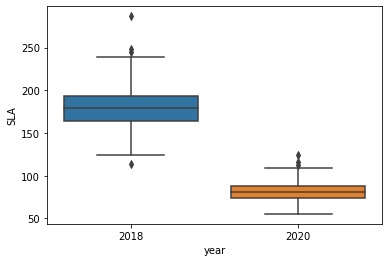

In [12]:
sns.boxplot(y= trait, x='year', data=data)

In [13]:
#defining a function to remove the outliers
def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1=datacolumn.quantile(0.25)
 Q3=datacolumn.quantile(0.75)
 #Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [14]:
outlier_treatment(data[trait])


(-67.16692164689113, 329.2306520302035)

In [15]:
lowerbound,upperbound = outlier_treatment(data[trait])

In [16]:
rm_index =data[(data[trait] < lowerbound) | (data[trait] > upperbound)].index
rm_index

Int64Index([], dtype='int64')

In [17]:
data.drop(rm_index, axis=0 ,inplace=True)

In [18]:
# choose the years for grouping in the plots
year = data.loc[: , 'year']

In [19]:
data.shape


(587, 2171)

In [20]:
# define trait data
y = data.loc[: , trait]


In [21]:
#select the columns of HR data
spec_columns = [col for col in data if col.startswith('X')]


In [22]:
# Define the X by choosing only the predictors
X = data[spec_columns]


In [23]:
# Apply Savitzky Golay Filter
X = savgol_filter(X, window_length=5 , polyorder = 2)
X = pd.DataFrame(X, columns= spec_columns)

In [24]:
# Remove first 100 wawelengths
X = X.drop(X.columns[0:100], axis=1)

In [25]:
# Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)

In [26]:
# Choose from the X based on filtering array
X = X.iloc[: , column_filter]


In [27]:
X.head()

,X450,X455,X460,X465,X470,X475,X480,X485,X490,X495,...,X2450,X2455,X2460,X2465,X2470,X2475,X2480,X2485,X2490,X2495
0,0.072084,0.072281,0.074527,0.073938,0.073444,0.073933,0.074270,0.074302,0.074556,0.077044,...,0.067297,0.065572,0.064134,0.062460,0.061316,0.059724,0.058408,0.057898,0.057136,0.056414
1,0.071562,0.070789,0.072950,0.072189,0.071799,0.072144,0.072596,0.072355,0.072260,0.073828,...,0.078345,0.076368,0.074371,0.072508,0.071027,0.069200,0.068060,0.066575,0.065758,0.065334
2,0.067849,0.067549,0.069338,0.068589,0.068386,0.068461,0.068986,0.068710,0.068470,0.070524,...,0.075083,0.073046,0.070950,0.068873,0.067303,0.065461,0.063934,0.062901,0.061841,0.060885
3,0.064959,0.064509,0.066153,0.065387,0.065025,0.065148,0.065500,0.065179,0.065041,0.066772,...,0.064992,0.063572,0.061879,0.060338,0.059434,0.058130,0.057164,0.056357,0.055493,0.055044
4,0.066446,0.065801,0.067720,0.066706,0.066269,0.066451,0.066779,0.066488,0.066297,0.068251,...,0.067579,0.065932,0.064275,0.062884,0.061588,0.060099,0.059214,0.058285,0.057006,0.056741


In [28]:
Index = pd.Series(most_important_index_SLA.iloc[: , 1])

In [29]:
X_reduced = X.loc[:, Index]

In [30]:
#define the cv
cv = RepeatedKFold(n_splits=10)
mse = []

In [31]:
#Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 40):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, X_reduced, y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(np.sqrt(score))

In [32]:
n_comp = mse.index(min(mse)) +1 

In [33]:
# split the dataset into training (60%) and testing (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y ,test_size=0.4) 

In [34]:
X.shape

(587, 410)

In [35]:
# Train the model
pls = PLSRegression(n_components= n_comp)
pls.fit(X_train, y_train)

PLSRegression(n_components=38)

In [36]:
# Calculate the RMSE
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

20.81167579393646

In [37]:
y_pred = pls.predict(X_test)

In [38]:
y_pred = pd.DataFrame(y_pred)

In [39]:
# Combine the 'year' and y_test for plotting and reset the index for combining with y_pred
y_test =pd.merge(y_test, year , left_index=True , right_index=True,  how='left').reset_index(drop=True)

In [40]:
y_test.head()

,SLA,year
0,203.064901,2018
1,160.435902,2018
2,176.804329,2018
3,228.057538,2018
4,76.447923,2020


In [41]:
type(y_pred)

pandas.core.frame.DataFrame

In [42]:
#Combine y_test and y_pred and get one data frame for seaborn scatter plot
data_plot = pd.concat([y_test, y_pred], axis = 1)

In [43]:
data_plot =data_plot.rename({0 : 'predicted'} ,axis =1)

In [44]:
data_plot.head()

,SLA,year,predicted
0,203.064901,2018,193.231696
1,160.435902,2018,174.697384
2,176.804329,2018,170.892242
3,228.057538,2018,209.774554
4,76.447923,2020,75.233206


In [45]:
# Calculate the spearman correlation , r2 and p value and pass them into the 'text'

from scipy.stats import pearsonr, spearmanr
#y_pred2 = [x[0] for x in data_plot.predicted]
r, p = spearmanr(data_plot[trait], data_plot.predicted)
r2 = r**2
text =r2, p
text = [np.round(r2, 2) for r2 in text]


Text(0.5, 1.0, 'SLA PLSR')

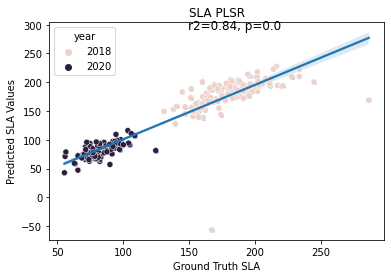

In [46]:
#plot the results
text1 = 'r2=%s, p=%s' % (text[0], text[1])
#sns.lmplot(x=trait, y='predicted',data=data_plot)
sns.regplot(x=trait, y='predicted' , scatter_kws={'s' : 15},data=data_plot)
xmin , xmax , ymin, ymax = plt.axis()
sns.scatterplot(x=trait, y='predicted', hue= 'year', data=data_plot).text((xmax)/2, ymax*0.96, text1, fontsize=12)
plt.xlabel('Ground Truth' + ' ' + trait)
plt.ylabel('Predicted' + ' ' + trait + ' ' + 'Values')
plt.title(trait + ' ' + 'PLSR')



In [47]:
data_2022 = pd.read_csv('sorghum_2022_whole.csv')

In [48]:
data_2022 =data_2022.loc[data_2022['355'].notnull(), :]

In [49]:
data_2022['CHL'] = data_2022[['CHLp1', 'CHLp2', 'CHLp3']].mean(axis=1)

In [50]:
data_2022['LWC'] = data_2022['LWC']/100

In [51]:
data_2022 = data_2022.loc[data_2022['Leaf_num'] != 2 , :]

In [52]:
#data_2022 = data_2022.loc[data_2022['Leaf_pos'] == 3 , :]

In [53]:
#data_2022 = data_2022.loc[data_2022['CHL']< 700 , :]

<AxesSubplot:ylabel='SLA'>

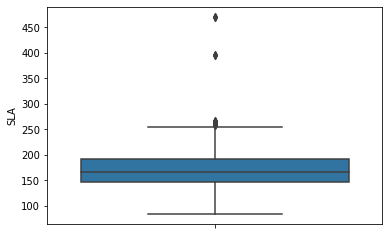

In [54]:
sns.boxplot(y= trait, data=data_2022)

In [55]:
import copy
data_test = copy.deepcopy(data_2022)

data = pd.read_csv
my_group = data_test.groupby(['Genotype', 'Rep']).mean()

my_group.head()

Leaf_num   CHLp1   CHLp2   CHLp3      FW       LA     DW  \
Genotype Rep                                                             
1        1         2.0  403.30  417.60  373.70   3.050  203.315  0.795   
         2         2.0  390.05  244.10  220.00   3.075  190.365  0.775   
2        1         1.0  765.90  749.80  761.50  15.300  588.120  4.090   
         2         2.0  552.60  405.25  148.25  15.500  608.395  4.470   
4        1         2.0  495.75  518.35  526.30  13.700  598.030  4.315   

                     SLA       THCK       LWC  ...      2492      2493  \
Genotype Rep                                   ...                       
1        1    257.092342  69.530235  0.729826  ...  0.075083  0.074767   
         2    251.344436  66.547158  0.736781  ...  0.075576  0.075305   
2        1    143.794621  38.439216  0.732680  ...  0.045286  0.044667   
         2    136.754379  39.219249  0.712232  ...  0.044450  0.044295   
4        1    138.274266  43.526700  0.685258  ...  0.063600  0.063374   

                  2494      2495      2496      2497      2498      2499  \
Genotype Rep                                                               
1        1    0.074717  0.074495  0.074277  0.073817  0.072667  0.072467   
         2    0.075219  0.075162  0.075687  0.075395  0.074362  0.073932   
2        1    0.043567  0.043349  0.043433  0.043200  0.043786  0.043700   
         2    0.044209  0.044067  0.043633  0.043225  0.042703  0.042633   
4        1    0.062941  0.062683  0.062683  0.062624  0.062445  0.062400   

                  2500         CHL  
Genotype Rep                        
1        1    0.073033  398.200000  
         2    0.073131  284.716667  
2        1    0.042268  759.066667  
         2    0.042550  368.700000  
4        1    0.062583  513.466667  

[5 rows x 2163 columns]

In [56]:
my_group = my_group.reset_index(level=['Genotype', 'Rep'])

In [57]:
outlier_treatment(my_group[trait])

(84.33015039342492, 257.0362606548748)

In [58]:
lowerbound,upperbound = outlier_treatment(my_group[trait])

In [59]:
rm_index =my_group[(my_group[trait] < lowerbound) | (my_group[trait] > upperbound)].index
rm_index

Int64Index([0, 40, 41], dtype='int64')

In [60]:
my_group.drop(rm_index, axis=0 ,inplace=True)

In [61]:
y_test = my_group.loc[:, trait]

In [62]:
y_test.shape

(117,)

In [63]:
X_total = my_group.iloc[:, 13:2164]

In [64]:
X_total.drop(columns = X_total.columns[0:100], inplace = True) 

In [65]:
X_total

,450,451,452,453,454,455,456,457,458,459,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
1,0.089735,0.089894,0.089596,0.089757,0.090451,0.090961,0.091022,0.091035,0.091390,0.091730,...,0.076182,0.075576,0.075305,0.075219,0.075162,0.075687,0.075395,0.074362,0.073932,0.073131
2,0.049967,0.050133,0.049900,0.049733,0.049900,0.050400,0.051033,0.051267,0.050967,0.051233,...,0.045781,0.045286,0.044667,0.043567,0.043349,0.043433,0.043200,0.043786,0.043700,0.042268
3,0.048267,0.048250,0.048000,0.048017,0.048467,0.048660,0.048919,0.049087,0.049033,0.049333,...,0.044300,0.044450,0.044295,0.044209,0.044067,0.043633,0.043225,0.042703,0.042633,0.042550
4,0.067517,0.067321,0.067967,0.068417,0.068267,0.068000,0.067867,0.068286,0.069100,0.068917,...,0.064010,0.063600,0.063374,0.062941,0.062683,0.062683,0.062624,0.062445,0.062400,0.062583
5,0.063735,0.063083,0.063350,0.063783,0.063867,0.063392,0.063017,0.063304,0.064133,0.064033,...,0.059400,0.058808,0.058487,0.058267,0.058083,0.058216,0.058133,0.057967,0.057863,0.057836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.091942,0.092791,0.093003,0.093339,0.093955,0.094083,0.094451,0.094993,0.095507,0.095401,...,0.090411,0.090124,0.089853,0.089571,0.088992,0.088277,0.087723,0.086604,0.086253,0.086805
116,0.073563,0.074333,0.074651,0.074866,0.075229,0.075790,0.076105,0.076172,0.076220,0.076790,...,0.064000,0.063292,0.063044,0.062767,0.062450,0.062633,0.062533,0.062028,0.061886,0.062250
117,0.083447,0.083765,0.084466,0.084728,0.084711,0.085620,0.085737,0.085617,0.085999,0.086403,...,0.072619,0.072563,0.072436,0.073017,0.072750,0.071733,0.071446,0.071167,0.070800,0.071067
118,0.054250,0.054150,0.054483,0.055017,0.055515,0.055820,0.056068,0.056067,0.055802,0.056333,...,0.071167,0.070477,0.070030,0.070067,0.069821,0.069652,0.069317,0.068733,0.068336,0.067793


In [66]:
#select the columns of HR data
spec_columns2 = X_total.columns

In [67]:
# Apply Savitzky Golay Filter
X_total = savgol_filter(X_total, window_length=5 , polyorder = 2)
X_total = pd.DataFrame(X_total, columns= spec_columns2)

In [68]:
X_total.head()

,450,451,452,453,454,455,456,457,458,459,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.089846,0.089648,0.089668,0.089825,0.090412,0.090904,0.091023,0.091099,0.091373,0.091713,...,0.076116,0.075635,0.075306,0.075159,0.075329,0.075560,0.075286,0.074560,0.073873,0.073128
1,0.050043,0.049975,0.049917,0.049756,0.049917,0.050429,0.050999,0.051161,0.051124,0.051182,...,0.045737,0.045338,0.044519,0.043733,0.043352,0.043283,0.043425,0.043716,0.043314,0.042473
2,0.048338,0.048098,0.048029,0.048090,0.048380,0.048701,0.048917,0.049027,0.049113,0.049329,...,0.044342,0.044367,0.044338,0.044218,0.044019,0.043672,0.043164,0.042791,0.042594,0.042555
3,0.067364,0.067646,0.067913,0.068341,0.068287,0.067986,0.067916,0.068392,0.068904,0.068971,...,0.063989,0.063677,0.063308,0.062967,0.062718,0.062661,0.062597,0.062458,0.062460,0.062551
4,0.063605,0.063350,0.063330,0.063757,0.063793,0.063400,0.063076,0.063420,0.063957,0.064038,...,0.059325,0.058874,0.058478,0.058237,0.058153,0.058159,0.058132,0.057978,0.057888,0.057822


In [69]:
column_filter = np.arange(0,2050,5)  ## creating an index for column filtering
X_test= X_total.iloc[:, column_filter] # selecting the filtered columns 

In [70]:
X_test.columns = X.columns

In [71]:
X_test= X_test.loc[:,Index]

In [72]:
X_test.shape

(117, 300)

In [73]:
#define the cv
cv = RepeatedKFold(n_splits=10)
mse = []

In [74]:
#Calculate MSE using cross-validation, adding one component at a time
#for i in np.arange(1, 40):
 #   pls = PLSRegression(n_components=i)
  #  score = -1*model_selection.cross_val_score(pls, X, y, cv=cv,
   #            scoring='neg_mean_squared_error').mean()
    #mse.append(np.sqrt(score))

In [75]:
#n_comp = mse.index(min(mse)) +1 

In [76]:
rsqu = [] 
for i in np.arange(1, 50):
    pls = PLSRegression(n_components= i)
    pls.fit(X_reduced, y)
    y_pred = pls.predict(X_test)
    r , p = spearmanr(y_test , y_pred)
    rsqu.append(r**2)
    n_comb = rsqu.index(max(rsqu)) +1

In [77]:
# Train the model
pls = PLSRegression(n_components=n_comb)
pls.fit(X_reduced, y)

PLSRegression(n_components=13)

In [78]:
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

43.30559731082121

In [79]:
y_pred = pls.predict(X_test)

<AxesSubplot:xlabel='SLA', ylabel='Predicted SLA values'>

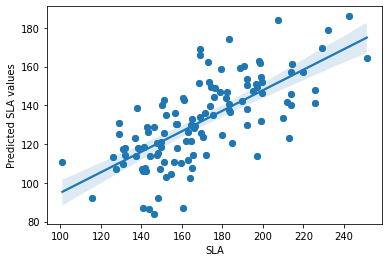

In [80]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted' + ' ' + trait +  ' ' 'values')
plt.xlabel('Ground truth LWC measurements')
sns.regplot(x = y_test , y = y_pred)


In [81]:
from scipy.stats import pearsonr, spearmanr
y_pred2 = [x[0] for x in y_pred]

r, p = spearmanr(y_test, y_pred2)
r2 = r**2
print(r2, p)

0.5272228008510553 1.991277445047835e-20


In [82]:
rsqu

[0.10543586790858933,
 0.27366590990290146,
 0.2443303462528103,
 0.22646182403546555,
 0.25957611713926854,
 0.4165431601630508,
 0.3787258917969469,
 0.4596278751116121,
 0.5106522304603429,
 0.5102132567686581,
 0.5169469711422482,
 0.5218178165219233,
 0.5272228008510553,
 0.5201844579616041,
 0.49587522962033725,
 0.4411735486790245,
 0.4425781545942715,
 0.42563554473635884,
 0.4179952204159505,
 0.3784400487670538,
 0.325189980603311,
 0.2898924141543356,
 0.29441223276719114,
 0.2985410771935748,
 0.3344849583689873,
 0.35990289734585285,
 0.40392159380747467,
 0.3435067648537719,
 0.2853915467112251,
 0.28738044373504695,
 0.1877855705724391,
 0.15813402219003908,
 0.14170182992376026,
 0.14037362882096913,
 0.19325384666564113,
 0.24303574594341074,
 0.22197712095087324,
 0.2409494694730354,
 0.20350538093441092,
 0.1903333326737423,
 0.18044257294742996,
 0.20877157694403273,
 0.2594997712228757,
 0.25815792105576707,
 0.26802720381902617,
 0.2703286234523532,
 0.29515265166